In [1]:
import os
base_dir = 'C:\Users\Ben\Documents\GitHub\expression_broad_data'
os.chdir(base_dir) 
from core import expression_plots 
from core import io_library 
#from IPython.core.debugger import Tracer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from Bio import SeqIO
import json
#import glob
# import fnmatch
import re

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#Only need to do this once
#Make new ortholog matrix for S.Cer to K.Lac and vice versa using YGOB data
all_ortholog_file = '\expression_data\ortholog_files_YGOB\YGOB_pillars.txt'

species1 = 'Kluyveromyces lactis'
species2 = 'Saccharomyces cerevisiae' 
orth_lookup = io_library.write_YGOB_orth_lookup_table(species1, species2, base_dir, all_ortholog_file)
#Wierd case: Scer_YGOB_YDR134C	KLLA0F20031g

In [ ]:
all_ortholog_file = '\expression_data\ortholog_files_YGOB\YGOB_pillars.txt'

species2 = 'Kluyveromyces lactis'
species1 = 'Saccharomyces cerevisiae' 
orth_lookup_SCer_KLac = io_library.write_YGOB_orth_lookup_table(species1, species2, base_dir, all_ortholog_file)

In [8]:
#Load dictionary of YGOB orthologs
#Make set of unmatched K.Lactis orthologs and count them up

orth_dir_YGOB = os.path.normpath(base_dir + "/expression_data/ortholog_files_YGOB/")
orth_dict_YGOB = io_library.read_orth_lookup_table('Kluyveromyces lactis', 'Saccharomyces cerevisiae', orth_dir_YGOB)

kl_unmatched_orthologs = []
for kl_gene, value in orth_dict_YGOB.iteritems():
    if value == ['NONE']:
        kl_unmatched_orthologs.append(kl_gene)

print ('There are ' + str(len(kl_unmatched_orthologs)) + ' unmatched orthologs for K.Lactis v.s. S.Cerevisiae in the YGOB ' + 
    'Pillars file.  This is more than the 488 KL singletons in the original paper.')

There are 689 unmatched orthologs for K.Lactis v.s. S.Cerevisiae in the YGOB Pillars file.  This is more than the 488 KL singletons in the original paper.


In [5]:
#Make KL to SC ortholog mapping (used in sc_vs_kl_pka_inhibition)

#Make a dataframe with KL genes, data, and SC Ortholog names by merging with a dataframe made up of three smaller dataframes
#from the KL data
#1) KL Genes with a single SC Ortholog
#2) KL Genes with the first of two SC orthologs
#3) KL Genes with the second of two SC orthologs
#Also including a column to indicates whether a particular gene is 1:2 - i.e. one SC Gene for two KL genes.

#Eventually we may find some KL specific duplications in which case we will
#need to be careful about the merge - the key will not be unique so we would add 
#A separate column

#First make dataframes to do the joins out of the ortholog matrix. 
species1 = 'Kluyveromyces lactis'
species2 = 'Saccharomyces cerevisiae' 
orth_dirname = base_dir + '\expression_data\ortholog_files_YGOB\\'
orth_lookup_SCer_KLac_dict = io_library.read_orth_lookup_table(species1, species2, orth_dirname) 

N_sc_orthologs_11 = []
kl_genename_11 = []
sc_genename_11 = []

N_sc_orthologs_21 = []
kl_genename_21 = []
sc_genename_21 = []

N_sc_orthologs_22 = []
kl_genename_22 = []
sc_genename_22 = []

for item in orth_lookup_SCer_KLac_dict.iteritems():
    if item[1][0] != 'NONE':  
        if len(item[1])==1: 
            N_sc_orthologs_11.append(len(item[1]))
            kl_genename_11.append(item[0])
            sc_genename_11.append(item[1][0])
        elif len(item[1])==2: 
            N_sc_orthologs_21.append(len(item[1]))
            kl_genename_21.append(item[0])
            sc_genename_21.append(item[1][0])
            
            N_sc_orthologs_22.append(len(item[1]))
            kl_genename_22.append(item[0])
            sc_genename_22.append(item[1][1])

kl_orthologs_dict_11 = {'N SCer Orthologs' : N_sc_orthologs_11,
                        'kl_genename' : kl_genename_11, 
                        'sc_genename' : sc_genename_11}

kl_orthologs_dict_21 = {'N SCer Orthologs' : N_sc_orthologs_21,
                        'kl_genename' : kl_genename_21, 
                        'sc_genename' : sc_genename_21}

kl_orthologs_dict_22 = {'N SCer Orthologs' : N_sc_orthologs_22,
                        'kl_genename' : kl_genename_22, 
                        'sc_genename' : sc_genename_22}



kl_orthologs = pd.concat([pd.DataFrame(kl_orthologs_dict_11),pd.DataFrame(kl_orthologs_dict_21),pd.DataFrame(kl_orthologs_dict_22)])


kl_orthologs.to_pickle(orth_dirname + "\\kl_orthologs.pkl")

#This is only the orthologs from YGOB - it might benefit from the blast mapping below in the future. 




In [8]:
#Find Accession number from KL Gene ID - outputs a file "unmatched_orthologs_list.txt" that has gene IDs from ensembl for a given
#KL gene in order to use it to blast as a group. 
#Only need to run once 

# Latest version of gff utils wont work in canopy. 
# gff_dir = "C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\PKA\Bioinformatics\KL_GFF\\"
# gff_fname = 'Kluyveromyces_lactis.ASM251v1.32.chromosome.F.gff3'
# gff_db_fname = 'gffutil\KLac_CHR_F.db'

# KL_chr_E = gffutils.   #.create_db(fn, dbfn='test.db', force=True)

seq_dir = "C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\kl_proteins_ensembl\\"
seq_fname = 'Kluyveromyces_lactis.ASM251v1.pep.all.fa'

handle = open(os.path.normpath(seq_dir+seq_fname), "rU")
id_dict = {}
for record in SeqIO.parse(handle, "fasta"):
    gene = record.description.split()[7].split(':')[1][:-1]+'g'
    gene_id = record.id
    id_dict[gene] = gene_id
handle.close()

#Make List of ids from unmatched orthologs
kl_unmatched_orth_dir = 'C:\Users\Ben\Documents\GitHub\expression_broad_data\scripts\kl_unmatched_ortholog_files\\'
kl_unmatched_orth_ids_fname = 'unmatched_orthologs_list.txt'
kl_unmatched_orth_ids = open(os.path.normpath(kl_unmatched_orth_dir + kl_unmatched_orth_ids_fname), 'w')
for gene in kl_unmatched_orthologs:
    try: 
        line = id_dict[gene] + '\n'
        kl_unmatched_orth_ids.write(line)
    except:
        pass
kl_unmatched_orth_ids.close()


Used pBlast from NCBI on the unmatched orthologs list txt file and outputed a set of JSON files into an unmatched ortholog files folder: kl_unmatched_ortholog_files\ZDNR6H1R01R-Alignment.  Ran job for a max of 10 results, only for W303, S288C, and Sigma 1278b

In [34]:
#Parse results to get all SC blast hits for each KL gene. Generates a datafram with KL Gene, KL ID, SC ID, log10_evalues, and total_scores from blast 
blast_results_dir = 'C:\Users\Ben\Documents\GitHub\expression_broad_data\scripts\kl_unmatched_ortholog_files\ZDNR6H1R01R-Alignment\\' 
blast_results_files = [filename for filename in os.listdir(blast_results_dir) if '_' in filename]

#for results_file in blast_results_files: 
accession_ids_KL = []
kl_genes = []
accession_ids_SC = []
log10_evalues = []
total_scores = []
results_filenames = []

for results_file in blast_results_files: 
    blast_results = json.load(open(os.path.normpath(blast_results_dir + results_file), 'r'))
    accession_id_KL = blast_results.items()[0][1]['report']['results']['search']['query_id'].split('.')[0]
    kl_gene = blast_results.items()[0][1]['report']['results']['search']['query_title'].split()[0][0:-1]+'g'
    hits = blast_results.items()[0][1]['report']['results']['search']['hits']
    #for each hit record log 10 evalue and total score
    for hit in hits:
        for hit_description in hit['description']: 
            accession_ids_KL.append(accession_id_KL)
            kl_genes.append(kl_gene)
            accession_ids_SC.append(hit_description['id'].split('|')[3])
            #would like to use accession number but yeast mine requires the version i.e. NP_014274.1 v.s. NP_014274
            #Pick out the max value (score) if there is more than one 'hsps'
            evalues_scores = [(np.log10(hsp['evalue']),hsp['bit_score']) for hsp in hit['hsps']]
            score_argmin = np.argmin([evalue_score[0] for evalue_score in evalues_scores])
            total_scores.append(evalues_scores[score_argmin][1])
            log10_evalues.append(evalues_scores[score_argmin][0])
            results_filenames.append(results_file)


blast_results_dict = {}
blast_results_dict['KL ID'] = accession_ids_KL
blast_results_dict['KL Gene'] = kl_genes
blast_results_dict['SC ID'] = accession_ids_SC
blast_results_dict['total_scores'] = total_scores
blast_results_dict['log10_evalues'] = log10_evalues
blast_results_dict['results filename'] = results_filenames
blast_results_df = pd.DataFrame(blast_results_dict)
blast_results_df


,KL Gene,KL ID,SC ID,log10_evalues,results filename,total_scores
0,KLLA0E14433g,CAG99687,NP_013043.1,-125.393804,ZDNR6H1R01R_10.json,367.8510
1,KLLA0E02157g,CAG99132,NP_013741.1,0.590086,ZDNR6H1R01R_100.json,25.0238
2,KLLA0E00287g,CAG99047,NP_010036.1,-50.829290,ZDNR6H1R01R_103.json,182.5700
3,KLLA0E00287g,CAG99047,NP_010845.1,-50.727210,ZDNR6H1R01R_103.json,182.1850
4,KLLA0E00287g,CAG99047,NP_014470.1,-50.511428,ZDNR6H1R01R_103.json,181.8000
5,KLLA0E00287g,CAG99047,NP_012316.1,-50.283550,ZDNR6H1R01R_103.json,181.0300
6,KLLA0E00287g,CAG99047,NP_013724.1,-50.104882,ZDNR6H1R01R_103.json,180.2590
7,KLLA0E00287g,CAG99047,NP_012692.3,-49.962605,ZDNR6H1R01R_103.json,180.2590
8,KLLA0E00287g,CAG99047,NP_014486.1,-49.764888,ZDNR6H1R01R_103.json,179.4890
9,KLLA0E00287g,CAG99047,NP_010087.1,-45.420263,ZDNR6H1R01R_103.json,171.0140


(array([ 987.,  241.,  119.,  107.,   70.,   49.,   42.,   40.,   30.,
           8.,   12.,   20.,    3.,    5.,    4.,    1.,    3.,    0.,
           0.,    1.,    1.,    2.,    1.,    2.,    1.,    0.,    0.,
           0.,    1.,    2.]),
 array([   20.7866 ,    89.08238,   157.37816,   225.67394,   293.96972,
          362.2655 ,   430.56128,   498.85706,   567.15284,   635.44862,
          703.7444 ,   772.04018,   840.33596,   908.63174,   976.92752,
         1045.2233 ,  1113.51908,  1181.81486,  1250.11064,  1318.40642,
         1386.7022 ,  1454.99798,  1523.29376,  1591.58954,  1659.88532,
         1728.1811 ,  1796.47688,  1864.77266,  1933.06844,  2001.36422,
         2069.66   ]),
 <a list of 30 Patch objects>)

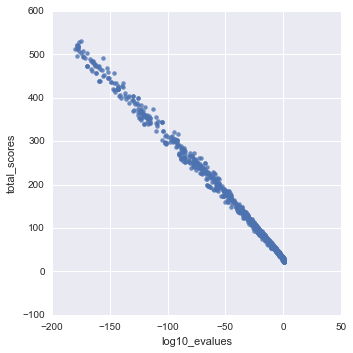

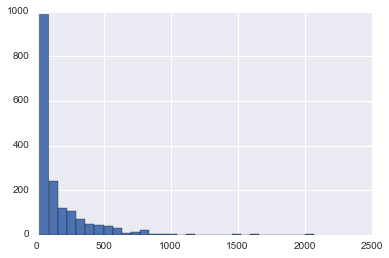

In [35]:

#scatter plot of total score v.s. EValue for each hit
sns.lmplot(x="log10_evalues", y="total_scores", data=blast_results_df)

# #Remove -inf and replace with -200 to plot in a histogram
# log10_evalues_remove_inf = []
# for result in blast_results_dict['log10_evalues']: 
#     if np.isneginf(result): 
#         log10_evalues_remove_inf.append(-200)
#     else: 
#         log10_evalues_remove_inf.append(result)

fix, ax = plt.subplots()
ax.hist(blast_results_df['total_scores'], bins = 30)

In [39]:
#Looking at a hit from a gene with a score of 53: 
#1745	KLLA0D02112g	CAH00258	NP_014594.2	-22.177882	ZDNR6H1R01R_93.json	91.2781
blast_results = json.load(open(os.path.normpath(blast_results_dir + 'ZDNR6H1R01R_93.json'), 'r'))
accession_id_KL = blast_results.items()[0][1]['report']['results']['search']['query_id'].split('.')[0]
kl_gene = blast_results.items()[0][1]['report']['results']['search']['query_title'].split()[0][0:-1]+'g'
hits = blast_results.items()[0][1]['report']['results']['search']['hits']
hits

[{u'description': [{u'accession': u'NP_014594',
    u'id': u'gi|37362693|ref|NP_014594.2|',
    u'sciname': u'Saccharomyces cerevisiae S288c',
    u'taxid': 559292,
    u'title': u'Rrt8p [Saccharomyces cerevisiae S288c]'}],
  u'hsps': [{u'align_len': 186,
    u'bit_score': 91.2781,
    u'evalue': 6.63924e-23,
    u'gaps': 16,
    u'hit_from': 157,
    u'hit_to': 339,
    u'hseq': u'ILQTNVLTAFVCRTLVLTHITNQIFDISLVLQDQDEFLNEVKVLPKPQKPHRKIDEPDAVRN---FNTIKGSRIFKIPRLLFRMFFKVSNFTSLTLLSLIPIVGPILANQLMAPKRTFTYLQRYFLLKGFSKKQAKDFQYEHYASFICFGMSAGLLELIPFFTIVTISSNTVGAAKWCTSLLKGER',
    u'identity': 61,
    u'midline': u'+LQ N  T    R  VL   TN IF+++L+ + Q E LN +K    P  P   ++  +   +   FNT      F   R LF   F       +TL+SL+PIVGP+ A  L  P R + Y   + + +  S K  +D  Y        FG++AGLLELIP F+ + + SN +    W    +K +R',
    u'num': 1,
    u'positive': 89,
    u'qseq': u'LLQCNAWTLRGVRNFVLPKFTNDIFELTLLRKGQIETLNSLKRRQLPACPELHLNNIEFWIHDVPFNT------FSFLRWLFVFIF-------ITLISLLPIVGPLAATILQTPDRAYGYYDVWMIRRRLSDKAKRDEYYSRLGQLW

There are 1752 KL to SC hits from the blast search.  The above plot shows that score and log10 evalue is highly correlated.  The histogram of scores shows a decay from 0, but no clear threshold choice. Looking at the above hit with a score of ~50 makes me confident that a score of 50 is not enough to call an ortholog. Made subset list to choose best SC hit above this threshold.  

In [58]:
#Built a Yeastmine Query to get SC IDs for all the SC Genes above the low threshold of 50.  There were 1056 hits above that level. 
#The query was generated using the file blast_ortholog_IDs.txt

cutoff_score = 50.0
blast_results_filtered = blast_results_df[blast_results_df['total_scores'] > cutoff_score]
print(len(blast_results_filtered))
#Extract Orf Name for hit - build list and use yeastmine query. 
blast_ortholog_IDs_fname = os.path.normpath(base_dir + '\scripts\kl_unmatched_ortholog_files\\blast_ortholog_IDs.txt')
blast_ortholog_IDs_file = open(blast_ortholog_IDs_fname, 'w')

for gene in blast_results_filtered['SC ID']:
    line = gene +'; '
    blast_ortholog_IDs_file.write(line)
blast_ortholog_IDs_file.close()

In yeastmine, the following genes were not found with 50.0 cutoff: 
XP_015332427.1 XP_015331607.1 XP_018220696.1 XP_015332090.1 XP_015331646.1 XP_018219166.1 XP_015331483.1 XP_015332029.1 XP_015332218.1 XP_015332004.1 XP_015331671.1 XP_015332309.1 XP_015331719.1 NP_014295.1 XP_015331503.1 XP_015331941.1 NP_012457.1 XP_015331771.1 XP_015332370.1 XP_015331846.1 XP_015331616.1 XP_015331534.1 XP_015331578.1 XP_015331615.1 XP_015331537.1 XP_015331656.1 XP_015332455.1 XP_015332244.1 XP_015332038.1 XP_015331843.1 XP_015331800.1 XP_015332067.1 XP_015332068.1 XP_015331937.1 XP_015331707.1 NP_012083.1

This is probably a result of one of those
What if it had another close hit that was actually on the list? 
KLLA0D14201g has no SC_orf but has a blast hit, NP_014295.1.  This gene mapped back to Leu4. I sent feedback into SGD to report this discrepancy. 

Yeastmine output was saved as blast_orthologs_SC_Orf_50.tsv. 

How to pick a good threshold. 

First it would be interesting to see how many pass each threshold level and what the distribution of the top hits is. 

For some top genes it would be interesting to see if they blast back to KL and how they do in YGOB. 

The result
861	KLLA0F21692g	CAG98756	NP_010694.1	-inf	ZDNR6H1R01R_371.json	2069.6600
maps to YDR406W, PDE15 https://www.ncbi.nlm.nih.gov/protein/NP_010694.1
its top blast result (just barely) is also KLLA0F21692g.  in YGOB neither the KL or SC gene seem to be close to one another.  They are clearly very closely related, but in different locations in the genome - perhaps they are from some horizontal gene transfer? 



In [131]:
#Pick a more stringent threshold and maps KL gene to the top SC gene above that threshold score. 

#Map blast hits back to SC Gene names. 
#Load SC data as a dataframe
blast_ortholog_SC_Orfs_fname = os.path.normpath(base_dir + '\scripts\kl_unmatched_ortholog_files\\blast_orthologs_SC_Orf_50.tsv')
blast_ortholog_SC_Orfs = pd.read_table(blast_ortholog_SC_Orfs_fname, header = None, names = ['SC ID', 'SC_orf','SC_name', 'SC_Name_description','common_name','SGD ID'])
blast_orthologs_df = pd.merge(blast_results_df, blast_ortholog_SC_Orfs, how='left', on='SC ID')

#Note that some SC gene names below the threshold will be assigned because they made it through the filter for other gene names.  
#Thus it is important to refilter before interpreting!

#For each KL gene pick out the top SC gene above a threshold score. 

#collect indices for top blast hits 
#Would be nice to keep more than one hit if the scores are close.  This just keeps the top score.
#Throws out line items if they are below this score
threshold = 80.0
index_list = []
for KL_gene in list(set(blast_orthologs['KL Gene'])): 
    #Iterate through each hit for a given gene: 
    score_to_beat = threshold
    ind_to_beat = None
    for hit in blast_orthologs[blast_orthologs['KL Gene'] == KL_gene ].iterrows():
        if hit[1]['total_scores'] > score_to_beat: 
            score_to_beat = hit[1]['total_scores']
            ind_to_beat = hit[0]
    if ind_to_beat != None: 
        index_list.append(ind_to_beat)

blast_orthologs_filtered = blast_orthologs.loc[index_list]

if len(blast_orthologs_filtered['KL Gene'])-len(set(blast_orthologs_filtered['KL Gene'])) > 0: 
    print "KL gene name occurs more than once"

#Integrate these into a new expanded ortholog file. 
blast_orthologs_KLac_SCer_fname = os.path.normpath(base_dir + '\scripts\kl_unmatched_ortholog_files\\blast_orthologs_KLac_SCer_80.txt')
blast_orthologs_KLac_SCer = open(blast_orthologs_KLac_SCer_fname, 'w')

for item in blast_orthologs_filtered.iterrows(): 
    if isinstance(item[1]['SC_orf'],str):
        line = item[1]['KL Gene'] + '\t' + item[1]['SC_orf'] + '\n'
        blast_orthologs_KLac_SCer.write(line)
    else:
        print item[1]['KL Gene'] + ' has no SC_orf but has a blast hit.'
        if item[1]['KL Gene']== 'KLLA0D14201g':
            line = item[1]['KL Gene'] + '\t' + 'YNL104C\n'
            blast_orthologs_KLac_SCer.write(line)
            print item[1]['KL Gene'] + ' manually set to YNL104C(Leu4) due to missing item in SGD database'
blast_orthologs_KLac_SCer.close()



KLLA0D14201g has no SC_orf but has a blast hit.
KLLA0D14201g manually set to YNL104C(Leu4) due to missing item in SGD database


In [ ]:
#Analysis to do: 

#Plot unmatched orthologs v.s. blast threshold for K.Lac

#Load PKA data and identify unmatched orthologs that are repressed and activated and have statistical significance 
#in the LFC.   Also output how many unmatched orthologs don't have genes that they aligned to

#Filter repressed and activated orthologs out if they come up as blast orthologs for a certain threshold. 


In [ ]:
#Old printout of unmatched orthologs
# print('in our ortholog file there are ' + str(len(orth_lookup_SCer_KLac_dict.keys())) + ' KLac genes of which ' +  
#        str(sum([1 for item in orth_lookup_SCer_KLac_dict.values() if item[0] == 'NONE'])) + ' have no ortholog, ' +
#       str(len(N_sc_orthologs_11)) + ' have 1 ortholog and ' + str(len(N_sc_orthologs_21)) + ' have two orthologs in SCer' +
#       ' for a total of ' + str(len(kl_orthologs)) + ' KLac-SCer ortholog pairs. \n After merging with data collected from ' +
#       ' the KL PKA inhibition experiment, there are ' + str(len(kl_PKA_data_sc_orthologs)) + ' KLac-SCer ortholog pairs with data.\n' +
#      'In Kieran\'s PKA inhibition dataset there are ' + str(len(mace_SC_PKA_data)) + ' SCer genes with data, of which ' +
#      str(len(kl_sc_PKA_data)) + ' are included in the KLac-SCer ortholog pair set - see below for genes that had YGOB names but not ' +
#      'SGD names')



# kl_sc_PKA_data_left = pd.merge(kl_PKA_data_sc_orthologs,mace_SC_PKA_data, on = 'sc_genename', how = 'left', indicator = True)

# print('The following genes are included in the YGOB ortholog file but are not standard orf names and thus have no SC data\n')
# #I wonder why this is slow 
# inds = [ind for ind in kl_sc_PKA_data_left['_merge'].index if kl_sc_PKA_data_left['_merge'][ind] == 'left_only']
# for ind in inds: 
#     print(kl_sc_PKA_data_left.iloc[ind]['sc_genename']) 
# print('of these, SDC25 (YLL016W) may be of interest - it is RAS GEF')

In [ ]:

#Old unmatched ortholog finder - only part here I would like is unmatched not alighned: 
#Count number of unmatched orthologs in KL dataset

# unmatched_ortholog_expression_df = pd.DataFrame.from_dict(unmatched_ortholog_expression, orient  = 'index') #, columns = 
# unmatched_ortholog_expression_df.columns = conditions

# #See if there are any high/low expressed genes in the unmatched ortholog set
# unmatched_ortholog_foldchange = unmatched_ortholog_expression_df[conditions[0]]
# plt.hist(unmatched_ortholog_foldchange)

# N = 4
# print 'there are ' + str(len(kl_unmatched_orthologs)) + \
#     ' K.Lactis orthologs that are unmatched in S.Cerevisiae\n Of those, ' + \
#     str(len(unmatched_orthologs_not_aligned)) + ' were not considered in the alignment.\n' +\
#     'Of those considered in the alignment, ' + \
#     str(len(unmatched_ortholog_foldchange[unmatched_ortholog_foldchange<-np.log(N)/np.log(2)])) + ' were repressed and ' + \
#     str(len(unmatched_ortholog_foldchange[unmatched_ortholog_foldchange>np.log(N)/np.log(2)])) + ' were induced greater than ' + str(N) + '-fold'

    
# #Print out table with annotations for top unmatched orthologs

# species = 'Kluyveromyces lactis'
# base_dir = 'C:\Users\Ben\Documents\GitHub\expression_broad_data\\'
# species_tab_file = 'expression_data\YGOB_genome_files\Klactis_genome.tab'
# annotation_lookup = io_library.load_YGOB_annotations(species, base_dir, species_tab_file)


# #Print out .tsv files for each cutoff: 
# top_unmatched_repressed_fname = os.path.normpath(base_dir + '\scripts\kl_unmatched_ortholog_files\\top_unmatched_repressed_nonorm.tsv')
# top_unmatched_repressed_file = open(top_unmatched_repressed_fname, 'w')
# top_unmatched_repressed = unmatched_ortholog_foldchange[unmatched_ortholog_foldchange<-np.log(N)/np.log(2)].sort_values()
# for gene_exp in top_unmatched_repressed.iteritems():
#     gene = gene_exp[0]
#     line = gene + '\t' + str(gene_exp[1])+ '\t' + annotation_lookup[gene] + '\n'
#     top_unmatched_repressed_file.write(line)
# top_unmatched_repressed_file.close()

# top_unmatched_activated_fname = os.path.normpath(base_dir + '\scripts\kl_unmatched_ortholog_files\\top_unmatched_activated_nonorm.tsv')
# top_unmatched_activated_file = open(top_unmatched_activated_fname, 'w')
# top_unmatched_activated = unmatched_ortholog_foldchange[unmatched_ortholog_foldchange>np.log(N)/np.log(2)].sort_values(ascending = False)
# for gene_exp in top_unmatched_activated.iteritems():
#     gene = gene_exp[0]
#     line = gene + '\t' + str(gene_exp[1])+ '\t' + annotation_lookup[gene] + '\n'
#     top_unmatched_activated_file.write(line)
# top_unmatched_activated_file.close()

This is just for notes

In [16]:
KL_gois = ['KLLA0E15203g',
'KLLA0E15181g',
'KLLA0A10505g',
'KLLA0F09977g',
'KLLA0E19713g',
'KLLA0D06083g',
'KLLA0F08371g',
'KLLA0D07414g',
'KLLA0F19382g',
'KLLA0A06996g',
'KLLA0B14575g',
'KLLA0E24927g',
'KLLA0E12035g']



#Repressed ['KLLA0A05511g','KLLA0A12001g','KLLA0F12804g','KLLA0F11682g','KLLA0B10219g','KLLA0C12034g','KLLA0A07777g','KLLA0F10835g','KLLA0C03256g']

for gene in KL_gois: 
    print id_dict[gene]  

CAG99722
CAG99721
CAH03048
CAG98242
CAG99930
CAH00429
CAG98168
CAH00489
CAG98658
CAH02898
CAH02573
CAH00162
CAR56742
